## Chopping off high $d_L$
It looks like the peak finder dips down a little towards the end for some (currently unknown) reason. The temporary solution to this is to simply stop before that. We'll also do some sigma clipping later to see if the issue is actually just that the errors are too large that far away since $d_L$ is in the denominator of the error functions.

In [1]:
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import arviz as az
from astropy.cosmology import Planck18
from tqdm import tqdm
import seaborn as sns
from MCMC_functions import *
from astropy.cosmology import units as cu

sns.set_context('notebook')
sns.set_palette('colorblind')

import matplotlib
matplotlib.rcParams['font.family'] = 'serif' # so these plots can go into thesis


%matplotlib inline

In [2]:
ms = generate_masses(f=0.5)
dLs = generate_dLs()
zs = dLs_to_zs(dLs)

m_det = ms*(1+zs)

## First up: Bootstrapping method

In [3]:
n_events = len(m_det)
n_dLs=10
n_mc = 8
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(dLs)
dL_max = max(dLs)
cutoff_d = 22000 #Mpc

In [4]:
m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
# d_Ls_mc = np.random.lognormal(mean=np.log(dLs), sigma=sigma_dls)
d_low_dl = dLs[dLs < cutoff_d]
dL_cent = np.quantile(d_low_dl, np.linspace(0.05, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

100%|██████████| 8/8 [00:39<00:00,  4.98s/it]


Text(0.5, 1.0, 'Ignore Power Law')

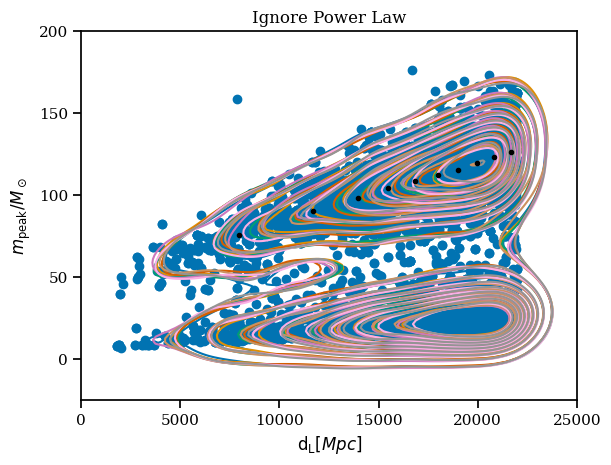

In [5]:
for run in tqdm(range(n_mc)):

    events = np.random.randint(n_events, size=n_events)
    
    m_dets = m_det[events]
    d_Ls = dLs[events]
    d_Ls_mc = d_Ls[d_Ls < cutoff_d]
    m_det_mc = m_dets[d_Ls < cutoff_d]
    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        redshifted_min = 25*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent[i]*u.Mpc))
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=redshifted_min)
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_Ls_mc, m_det_mc)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.ylim(top=200)
plt.xlim(left=0)
plt.title("Ignore Power Law")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
There were 208 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6185, but should be close to 0.8. Try to increase the number of tuning steps.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7174, but should be close to 0.8. Try to increase the number of tuning steps.


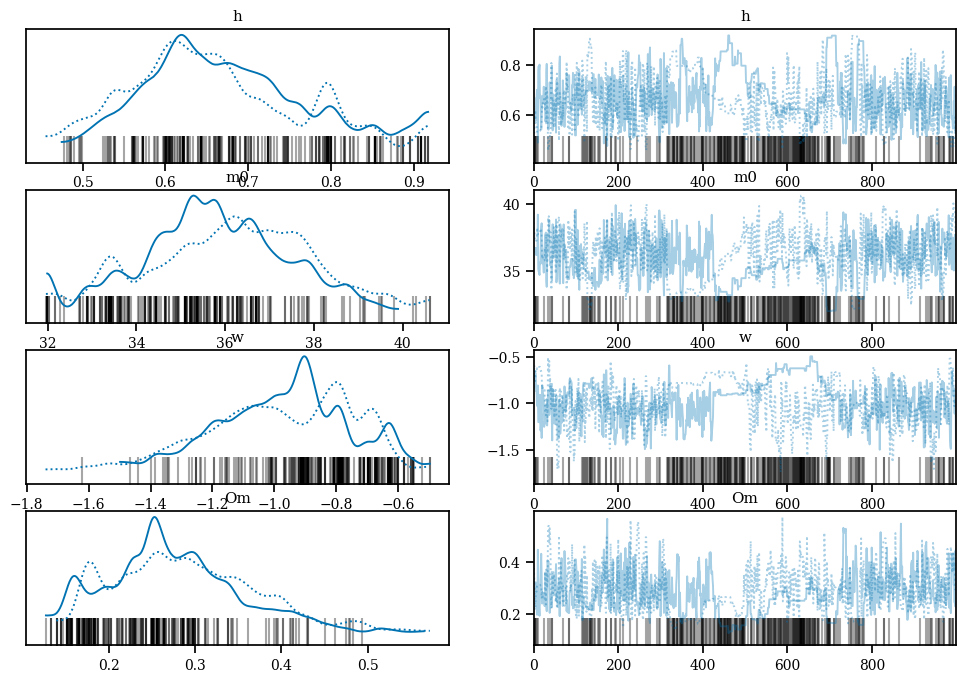

In [6]:
mu_ms = np.mean(mpeak_samples, axis=0)
sigma_ms = np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_ms, sigma_ms_obs=sigma_ms, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

## Now trying the emperical errors method:

In [7]:
m_dls = m_det/dLs
sigma_dls = sigma_dL(m_dls)
sigma_ms  = sigma_m(m_dls)

100%|██████████| 8/8 [01:04<00:00,  8.08s/it]


(-27.713754166098, 250.0)

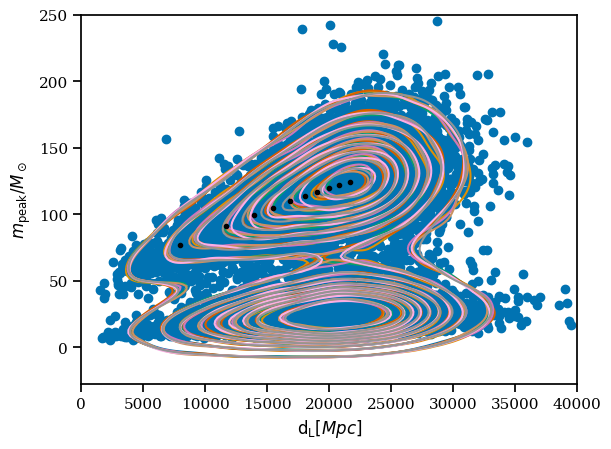

In [8]:
for run in tqdm(range(n_mc)):

    m_det_mc = np.random.lognormal(mean=np.log(m_det), sigma=sigma_ms)
    # print(m_det_mc[0])
    d_Ls_mc = np.random.lognormal(mean=np.log(dLs), sigma=sigma_dls)


    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        redshifted_min = 25*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent[i]*u.Mpc))
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=redshifted_min)
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_Ls_mc, m_det_mc)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.xlim(0,40000)
plt.ylim(top=250)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.


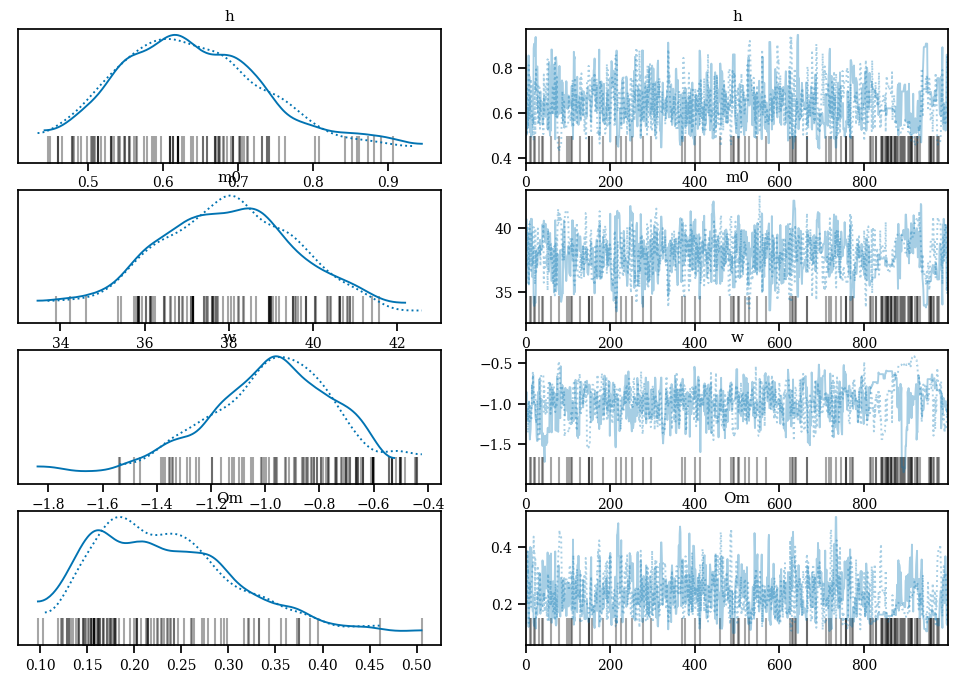

In [9]:
mu_ms = np.mean(mpeak_samples, axis=0)
sigma_ms = np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_ms, sigma_ms_obs=sigma_ms, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace